## This notebook is for performing EDA on the data I scraped earlier on Finnish houses & apartments.
I want to see what features contribute most to the price of the house.   
In addition, it would be nice to create a regression model to predict the price of a listing using only the common features.

In [480]:
import sqlite3
from sqlite3 import Error

import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
sns.set_palette('gist_earth_r',n_colors=8)
import matplotlib.pyplot as plt

# # Modeling
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression,Lasso,Ridge
import xgboost as xgb
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [481]:
def read_data_from_DB():
    try:
        path_to_DB = r"../Data/house.db"
        conn = sqlite3.connect(path_to_DB)
        df = pd.read_sql_query("SELECT * from house_features", conn)
    except Error as e:
        print(e)
        df = 0
    return df
df = read_data_from_DB()

In [482]:
df.head(5)


,ID,HOUSE_TYPE,HOUSE_ROOMS,ADDRESS,AREA,CITY,PRICE,SIZE,YEAR,LATITUDE,LONGITUDE
0,1,Kerrostalo,2 h + k,Mechelininkatu 17 A,Töölö,Helsinki,575000,81,1928,60.172709,24.920025
1,2,Kerrostalo,1h + kk + kph + lasitettu parveke,Porvoonkatu 5-7 A,Alppiharju,Helsinki,209000,28,1963,60.189479,24.950852
2,3,Omakotitalo,"3-4h, k, rh, 2wc, kuisti n. 115 m2 + saunaos....",Lainlukijantie 42,Torpparinmäki,Helsinki,398000,115,1954,60.263987,24.954653
3,4,Kerrostalo,1 h + kk + kph,Kauppalantie 13,Etelä-Haaga,Helsinki,199000,26,1963,60.211790,24.898284
4,5,Kerrostalo,2H + KK + S,Leikosaarentie 13,Vuosaari,Helsinki,16446,46,1996,60.202981,25.142185


Helsinki city center is quite large, but the if someone would have to point out *the* central point, they would either say "Narinkkatori" or "Kolmen sepän patsas".
I want to measure the distance between Narinkkatori and the listed house/apartment. My hypothesis is that the further away the location is from this central point, the less it will be valued.

The distance could be computed in various ways, but as we are possibly dealing with small distances ( $d<1$ km), we need to be careful when selecting the correct distance computation method.

Let $\lambda_1$,$\phi_1$ and $\lambda_2$,$\phi_2$ be the geographical longitude and latitude of two points 1 and 2, and $\Delta\lambda$,$\Delta\phi$ be their absolute differences. R is the radius of the earth (6371km)

We could use the spherical law of cosines:
- $d = R \cdot arccos(sin\phi_1sin\phi_2+cos\phi_1 cos\phi_2cos(\Delta\lambda)))$, but this is susceptible to rounding point errors.

A better alternative would be the Haversine formula:
- $d = archav(hav(\Delta\phi)+(1-hav(\Delta\phi)-hav(\phi_1+\phi_2))\cdot hav(\Delta\lambda))$,
- $hav(x) = sin^2(x/2)$

The simplest method would be a spherical projection onto a plane:
- $d = R\sqrt{(\Delta\phi)^2+(cos(\frac{\phi_1+\phi_2}{2})\Delta\lambda)^2}$



In [483]:
def compute_dist(lat1,lon1,lat2,lon2,dist="Spherical_to_plane"): #phi,lambda
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    if dist == "Spherical_to_plane":
        dist = 6371*np.sqrt((lat1-lat2)**2+(np.cos((lat1+lat2)/2)*(lon1-lon2)**2))
    elif dist == "Haversine":
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = (np.sin(dlat/2)**2 
         + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2)
        c = 2 * np.arcsin(np.sqrt(a)) 
        dist = 6371 * c
    return dist

In [484]:
print("With a projection of spherical coordinates to a plane: ",compute_dist(60.172709,24.920025,60.263987,24.954653))
print("With a the Haversine formula: ",compute_dist(60.172709,24.920025,60.263987,24.954653,dist="Haversine"))

With a projection of spherical coordinates to a plane:  10.506161724677145
With a the Haversine formula:  10.328266143722727


The Haversine formula probably gives better approximations in our case, as it does not overshoot the distance due to a projection. In the future we might want to add listings from cities far away from the capital area, and thus Haversine still would be able to give decent approximations.

In [485]:
coords_narinkkatori = 60.169673, 24.934854
# compute_dist(62.617156,29.716200,*coords_narinkkatori,dist="Haversine")
df["DIST_to_center"] = compute_dist(df["LATITUDE"],df["LONGITUDE"],*coords_narinkkatori,dist="Haversine")
df.head()

,ID,HOUSE_TYPE,HOUSE_ROOMS,ADDRESS,AREA,CITY,PRICE,SIZE,YEAR,LATITUDE,LONGITUDE,DIST_to_center
0,1,Kerrostalo,2 h + k,Mechelininkatu 17 A,Töölö,Helsinki,575000,81,1928,60.172709,24.920025,0.886916
1,2,Kerrostalo,1h + kk + kph + lasitettu parveke,Porvoonkatu 5-7 A,Alppiharju,Helsinki,209000,28,1963,60.189479,24.950852,2.373312
2,3,Omakotitalo,"3-4h, k, rh, 2wc, kuisti n. 115 m2 + saunaos....",Lainlukijantie 42,Torpparinmäki,Helsinki,398000,115,1954,60.263987,24.954653,10.544124
3,4,Kerrostalo,1 h + kk + kph,Kauppalantie 13,Etelä-Haaga,Helsinki,199000,26,1963,60.211790,24.898284,5.100788
4,5,Kerrostalo,2H + KK + S,Leikosaarentie 13,Vuosaari,Helsinki,16446,46,1996,60.202981,25.142185,12.045611


## Exploratory Data Analysis

### Quick data cleaning

In [486]:
df.nunique()

ID                5123
HOUSE_TYPE           7
HOUSE_ROOMS       1911
ADDRESS           4425
AREA               322
CITY                 2
PRICE             2587
SIZE               247
YEAR               132
LATITUDE          1909
LONGITUDE         1912
DIST_to_center    1912
dtype: int64

In [487]:
df.describe()

,ID,PRICE,SIZE,YEAR,LATITUDE,LONGITUDE,DIST_to_center
count,5123.000000,5.123000e+03,5123.000000,5123.000000,5123.000000,5123.000000,5123.000000
mean,2562.000000,3.918746e+05,69.637712,1922.699200,59.498026,24.553062,109.714792
std,1479.027045,3.495647e+05,44.116534,390.730156,6.878493,2.930704,801.690151
min,1.000000,0.000000e+00,12.000000,0.000000,-1.000000,-1.000000,0.138821
25%,1281.500000,2.280000e+05,44.000000,1976.000000,60.169571,24.732449,5.613297
50%,2562.000000,3.229000e+05,62.000000,2021.000000,60.189602,24.863569,9.454627
75%,3842.500000,4.578500e+05,83.000000,2022.000000,60.223192,24.961605,12.709800
max,5123.000000,9.300000e+06,670.000000,2024.000000,66.433223,29.813338,7160.644071


We know that:

- ID and the coordinates are not that useful in our analyses
- PRICE, SIZE,YEAR, and the coordinates have default values for missing data
- The distance to the center can be invalid (over 50km from the center are not in the capital area)

Houses that are really expensive are usually not valued by the market, but by the potential pool of buyers. Rich people have different values for such houses, and we probably are better of discarding the very expensive listings (> 1 000 000€) as they skew the analysis and are not as interesting to us (I can't afford a million euros).

In [488]:
df = df.drop(columns=["ID"]) if "ID" in df.columns else df
df = df[(
    df['PRICE'] > 0) &
    (df['PRICE'] < 1000000) &
    (df['SIZE'] > 0) &
    (df['YEAR'] > 0) &
    (df['LATITUDE'] > 0) &
    (df['LONGITUDE'] > 0) &
    (df['DIST_to_center'] > 0) &
    (df['DIST_to_center'] < 40)]

In [489]:
df.describe()

,PRICE,SIZE,YEAR,LATITUDE,LONGITUDE,DIST_to_center
count,4529.000000,4529.000000,4529.000000,4529.000000,4529.000000,4529.000000
mean,349919.168249,65.684478,2002.382866,60.197276,24.857851,9.125175
std,192029.003439,33.259587,29.508908,0.033147,0.145371,4.741059
min,7912.000000,12.000000,1850.000000,60.119687,24.458702,0.285216
25%,221000.000000,44.000000,1983.000000,60.170706,24.740631,5.539983
50%,316000.000000,61.000000,2021.000000,60.190264,24.875364,9.019101
75%,445000.000000,81.000000,2023.000000,60.221989,24.959512,12.328592
max,999100.000000,527.000000,2024.000000,60.426104,25.236193,30.006327


### Features

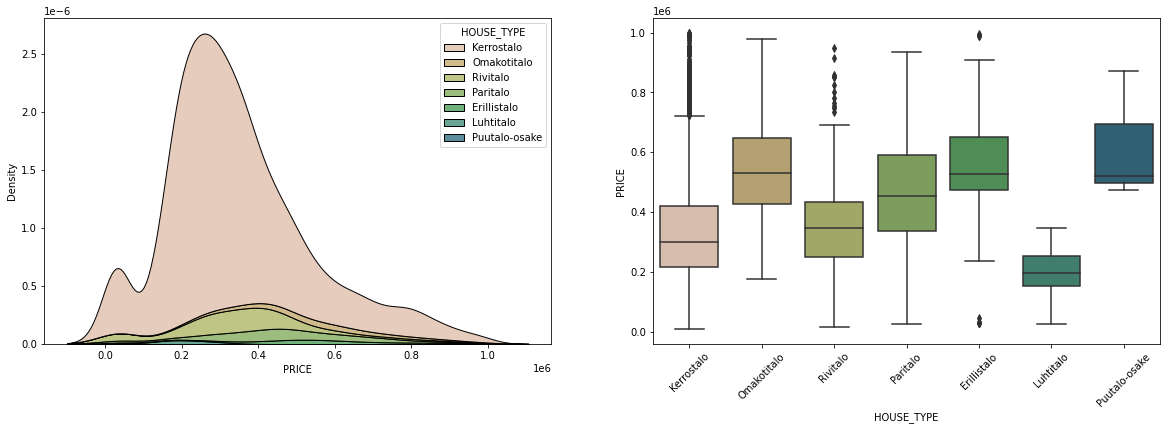

In [490]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 6))
sns.kdeplot(hue=df["HOUSE_TYPE"], x=df['PRICE'],fill=True,multiple='stack',ax=ax[0]) 
sns.boxplot(x=df["HOUSE_TYPE"], y=df['PRICE'],ax=ax[1])
ax[1].xaxis.set_tick_params(labelrotation =45)
plt.show()

Erillistalo (detached house),  Omakotitalo (house) and Puutalo-osake (Wood-house condominium (?)) have the highest prices among the different house types.   
Kerrostalo (apartment house) and Luhtitalo has the lest expensive listings.   
Let us see what the most expensive listings looks like:

In [491]:
df.nlargest(1, 'PRICE')

,HOUSE_TYPE,HOUSE_ROOMS,ADDRESS,AREA,CITY,PRICE,SIZE,YEAR,LATITUDE,LONGITUDE,DIST_to_center
3956,Kerrostalo,3h + kt + vh + s + las.parvekkeet n. 25m2,Itätuulenkuja 10 A 77,Tapiola,Espoo,999100,104,2023,60.174915,24.805771,7.163018


The most expensive listing is a big (104 $m^2$) new (2023) house only 7km from the city center. It costs just under 1 million €.   


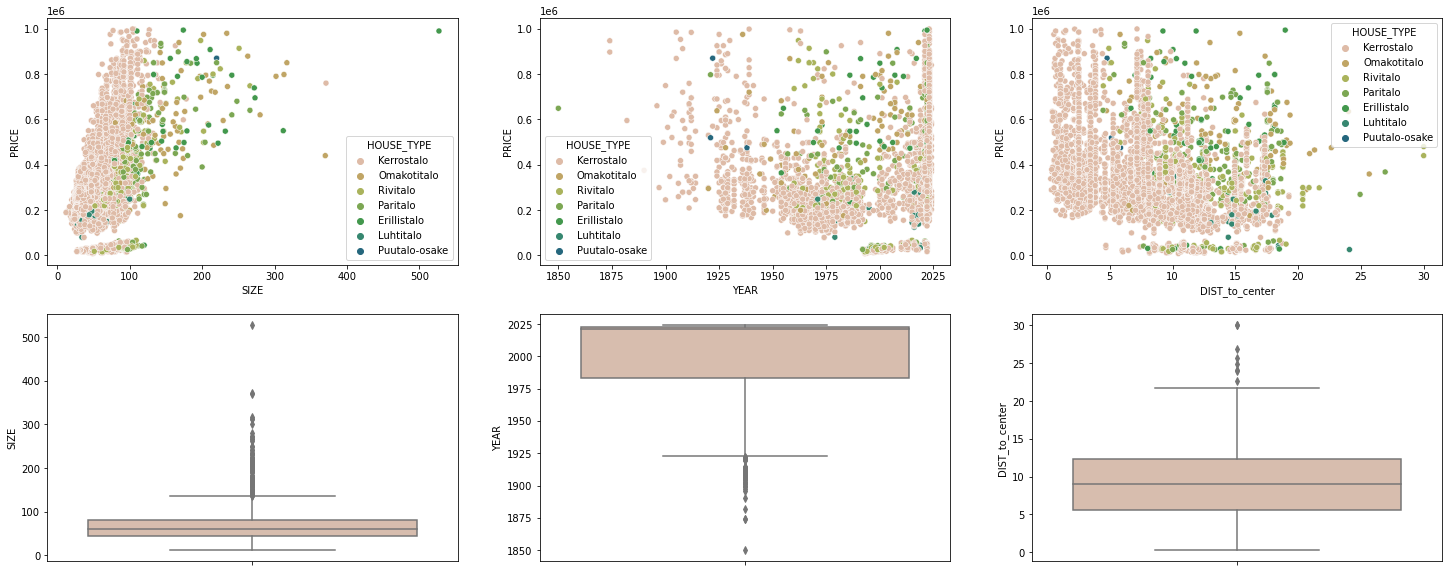

In [492]:
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(25, 10))
for i,col in enumerate(["SIZE","YEAR","DIST_to_center"]):
    sns.scatterplot(data=df,x=col, y='PRICE',hue='HOUSE_TYPE',ax=ax[0,i%3])
    sns.boxplot(data=df,y=col,ax=ax[1,i%3])
plt.show()

Larger houses are more expensive.   
The year when the house is built has a multimodal relationship with the price. There are certain years for which the house prices are larger than for other years.   
Distance to the center seems to be valued highly and thus the houses near the center are expensive

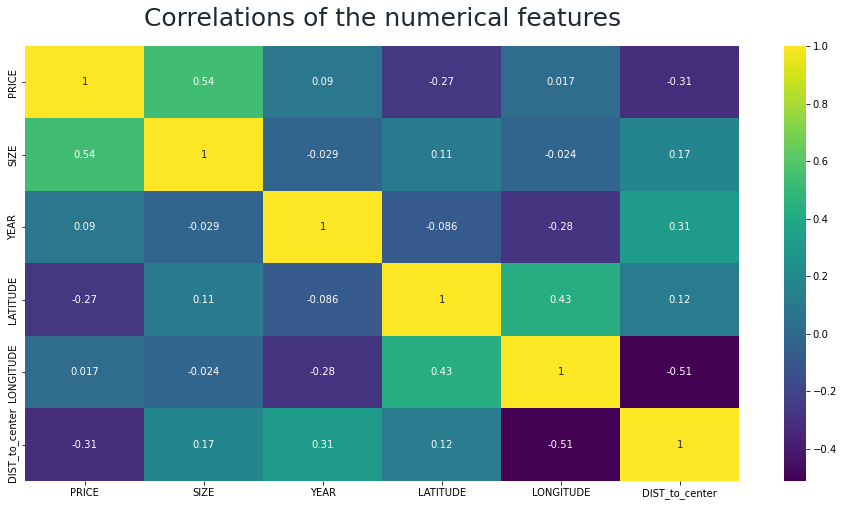

In [493]:
df_corr = df.corr()
plt.figure(figsize=[16,8])
plt.title("Correlations of the numerical features", size=25, pad=20, color='#1f2833')
sns.heatmap(df_corr, cmap="viridis", annot=True)
plt.show()

The size and the distance to the center seems to have highest correlations with the price of the listing.   
The distance to the center also has decent correlation with the year the house was built. This seems plausible as usually cities in Finland/Europe are built around and outwards from the oldest parts of the city. Helsinki centrum is mostly old building that have been renovated or left as is.  
The coordinates correlate with each other, and also with the distance to the center. This is obvious but we need to drop the coordinates later when implementing regression models to reduce multicollinearity

## Regression modeling

### Data preprocessing

In [494]:
feature_cols = ["HOUSE_TYPE","AREA","CITY","PRICE","SIZE","YEAR","DIST_to_center"]
df_for_regression = df[feature_cols]

# Drop unique area rows.
counts = df_for_regression['AREA'].value_counts()
df_for_regression = df_for_regression[~df_for_regression['AREA'].isin(counts[counts < 2].index)]

y = df_for_regression.pop("PRICE")
X = df_for_regression

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42,shuffle=True)

In [495]:
num_cols = list(X_train.select_dtypes([np.number]).columns)
cat_cols = [c for c in X_train.columns if c not in num_cols]

cat_idx = X.columns.get_indexer(cat_cols)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_idx),
    ]
)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print("Train data: ",X_train.shape)
print("Test data: ",X_test.shape)

Train data:  (3544, 218)
Test data:  (887, 218)


In [496]:
def show_diagnostics(X,y,model):
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=[25,6])
    # Predicted vs real values
    sns.scatterplot(x=y,y=model.predict(X),ax=ax[0])
    ax[0].set_title("Predicted vs real prices", size=25, pad=20, color='#1f2833')
    ax[0].axline((1, 1), slope=1, ls="--", c="0.2")
    ax[0].set_ylabel("Predicted price")
    ax[0].set_xlabel("Real price")
    # Residual plot
    sns.scatterplot(x=y,y=y-model.predict(X),color=".2", marker="o",ax=ax[1])
    ax[1].set_title("Real prices vs residuals", size=25, pad=20, color='#1f2833')
    ax[1].axline((0, 0), slope=0, ls="--", c="red")
    ax[1].set_ylabel("Residual")
    ax[1].set_xlabel("Real Price")

    # Cross validation score
    scores = cross_validate(model, X, y,scoring={'RMSE':'neg_root_mean_squared_error',
                                                            'MAE':'neg_mean_absolute_error',
                                                            'exp_var':'explained_variance',
                                                            'MAPE':'neg_mean_absolute_percentage_error'}, cv=5, n_jobs=-1)
    print(f"RMSE: {round(-scores['test_RMSE'].mean(),2)},\
            MAE: {round(-scores['test_MAE'].mean(),2)},\
            Explained variance: {round(scores['test_exp_var'].mean(),2)},\
            MAPE: {round(-scores['test_MAPE'].mean(),2)}")


### Modeling

Simple Linear regression

RMSE: 102959.65,            MAE: 68223.2,            Explained variance: 0.71,            MAPE: 0.55


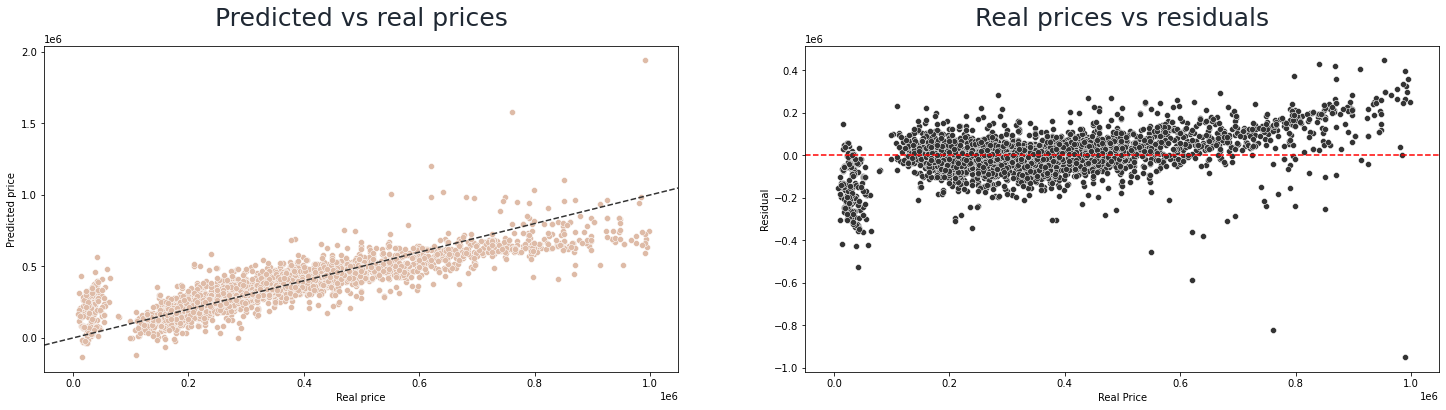

In [497]:
reg = LinearRegression().fit(X_train, y_train)
show_diagnostics(X_train,y_train,model=reg)

Ridge regression

RMSE: 102613.75,            MAE: 69489.96,            Explained variance: 0.71,            MAPE: 0.57


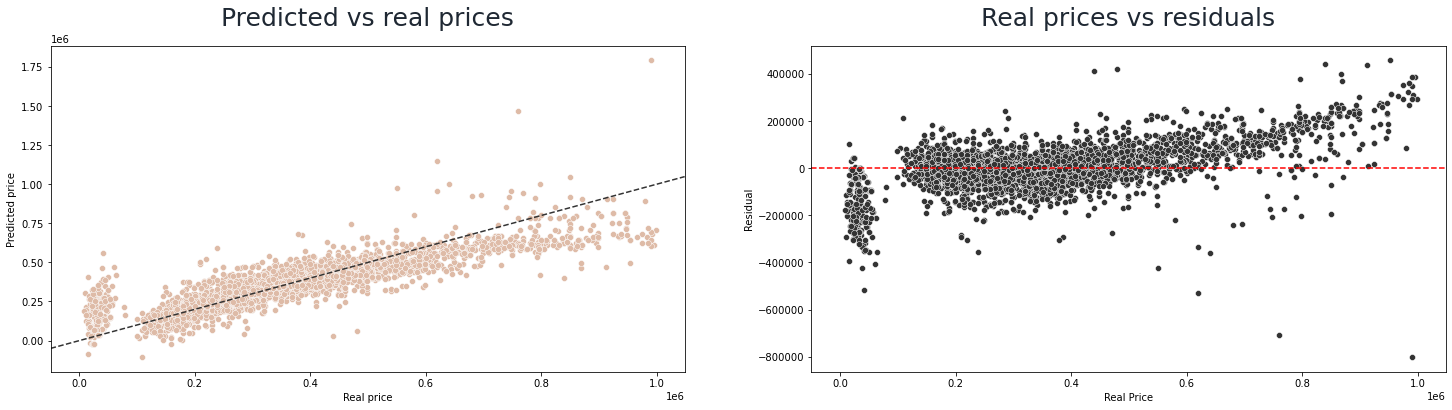

In [498]:
ridge = Ridge().fit(X_train, y_train)
show_diagnostics(X_train,y_train,model=ridge)

Lasso regression

RMSE: 102909.95,            MAE: 68172.46,            Explained variance: 0.71,            MAPE: 0.55


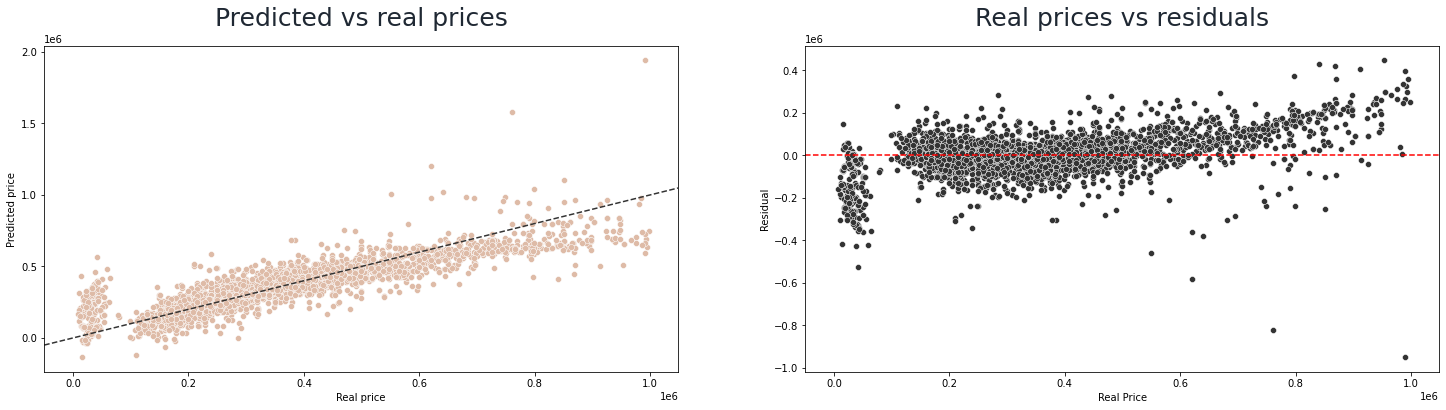

In [499]:
lasso_ = Lasso().fit(X_train, y_train)
show_diagnostics(X_train,y_train,model=lasso_)

XGBoost regression model

RMSE: 65800.47,            MAE: 39884.94,            Explained variance: 0.88,            MAPE: 0.25


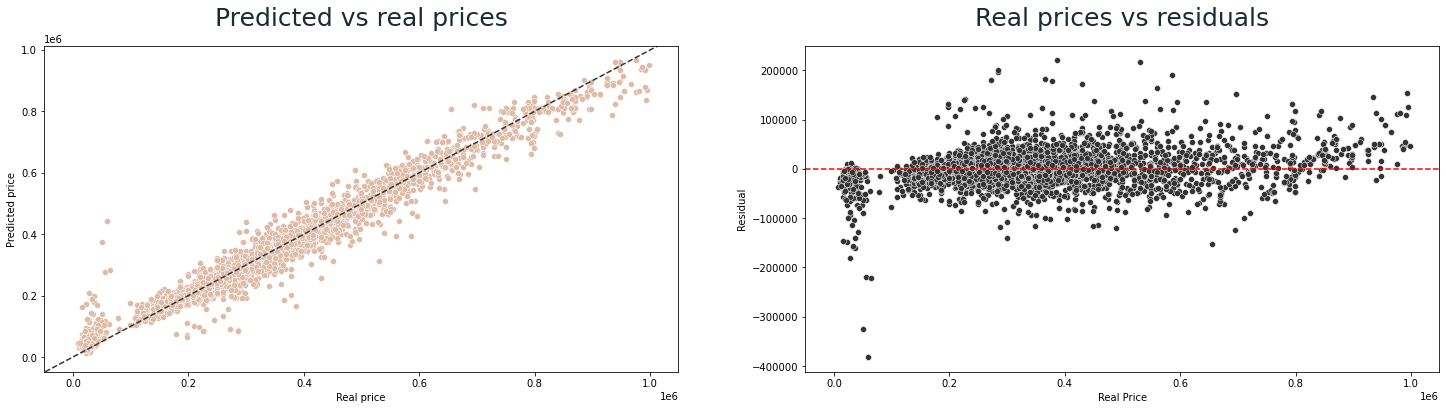

In [500]:
xgb_model = xgb.XGBRegressor(random_state=42,objective="reg:squarederror")
xgb_model.fit(X_train, y_train)
show_diagnostics(X_train,y_train,model=xgb_model)

The more complex XGBoost regression model seems to fit best to the data out of the box. Let's see how we can make this model even better.

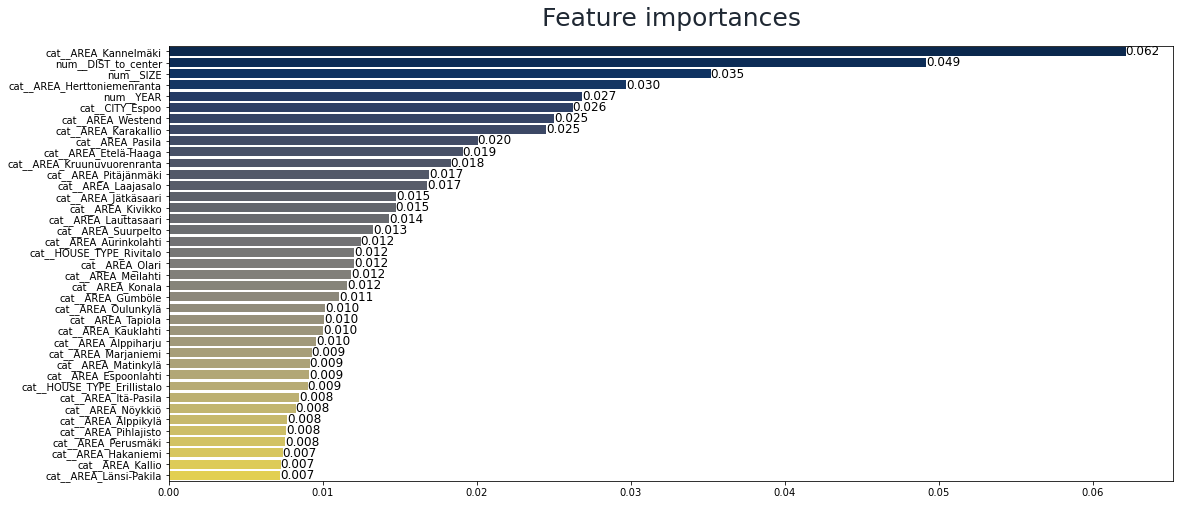

In [501]:
indices = np.argsort(xgb_model.feature_importances_)[::-1][1:40]
feature_names = preprocessor.get_feature_names_out()
plt.figure(figsize=[18,8])
ax = sns.barplot(y = feature_names[indices],x = xgb_model.feature_importances_[indices],order=feature_names[indices],palette=('cividis'))
plt.title("Feature importances", size=25, pad=20, color='#1f2833')
ax.bar_label(ax.containers[0], size="12",fmt='%.3f');

The distance to the center and the size of the listed house are very important to the overall price of the house. Some areas are also important when predicting the price. Maybe the XGBoost model is able to capture the information between the areas better than the simple linear models.

### Two-model approach

We can see that the XGBoost model does work quite well, but the residuals show us that there is some sort of bimodality in the data that the regression model is not able to capture.   
The houses that are listed with a price below 70k€ seem to come from different distribution, and their predicted prices are overestimated.   
To rectify this, we can try fitting two models, one for the low price houses, and another for the rest.

In [502]:
cut_off = 70000
low_price_data = X[y < cut_off]
high_price_data = X[y >= cut_off]

In [503]:
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(low_price_data, y[y<cut_off], train_size=0.8, random_state=42,shuffle=True)
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(high_price_data, y[y>=cut_off], train_size=0.8, random_state=42,shuffle=True)

X_train_low = preprocessor.fit_transform(X_train_low)
X_test_low = preprocessor.transform(X_test_low)
print("Train_low data: ",X_train_low.shape)
print("Test_low data: ",X_test_low.shape)
X_train_high = preprocessor.fit_transform(X_train_high)
X_test_high = preprocessor.transform(X_test_high)
print("Train_high data: ",X_train_high.shape)
print("Test_high data: ",X_test_high.shape)

Train_low data:  (230, 52)
Test_low data:  (58, 52)
Train_high data:  (3314, 213)
Test_high data:  (829, 213)


Low valued houses

RMSE: 2973.64,            MAE: 2063.8,            Explained variance: 0.93,            MAPE: 0.08


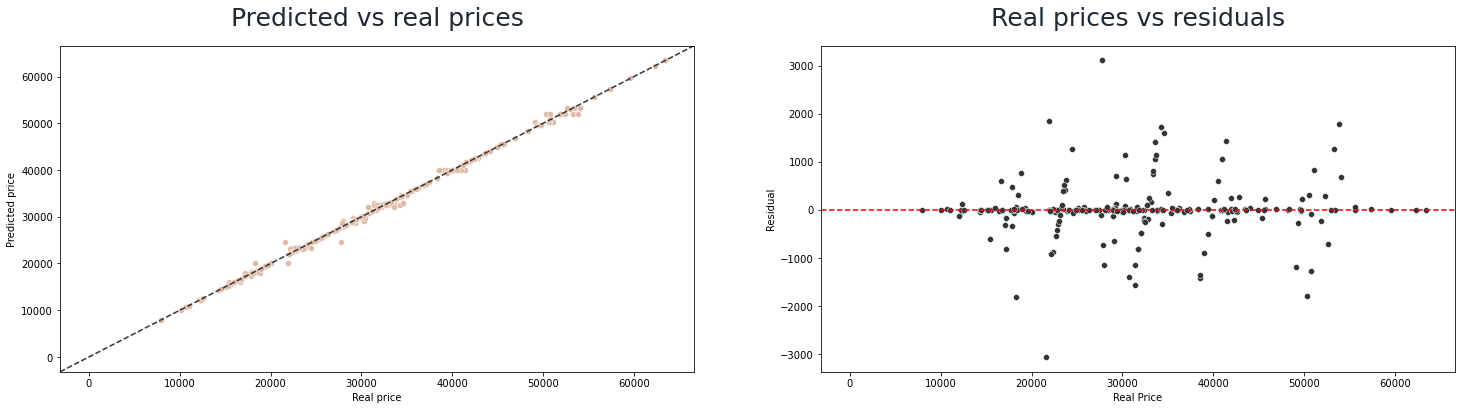

In [504]:
xgb_model_low = xgb.XGBRegressor(random_state=42,objective="reg:squarederror")
xgb_model_low.fit(X_train_low, y_train_low)
show_diagnostics(X_train_low,y_train_low,model=xgb_model_low)

High valued houses

RMSE: 54583.85,            MAE: 34373.76,            Explained variance: 0.91,            MAPE: 0.1


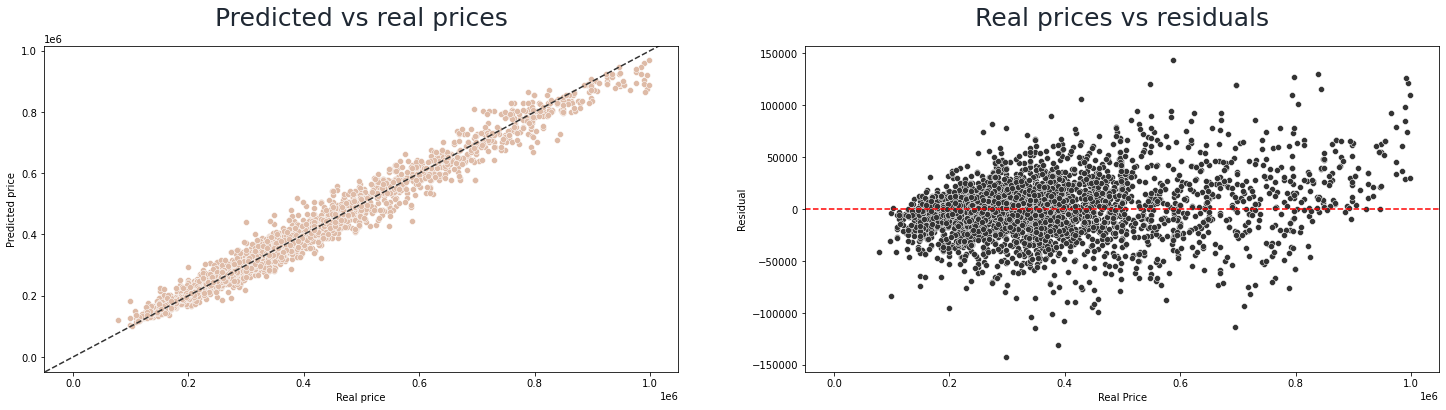

In [505]:
xgb_model_high = xgb.XGBRegressor(random_state=42,objective="reg:squarederror")
xgb_model_high.fit(X_train_high, y_train_high)
show_diagnostics(X_train_high,y_train_high,model=xgb_model_high)

Looks like the two-model approach work better than the one model approach. Let us test both models using the test sets.

RMSE: 66715.93,            MAE: 43819.14,            Explained variance: 0.88,            MAPE: 0.27
RMSE: 3209.93,            MAE: 2423.61,            Explained variance: 0.88,            MAPE: 0.09
RMSE: 64220.21,            MAE: 40124.64,            Explained variance: 0.87,            MAPE: 0.12


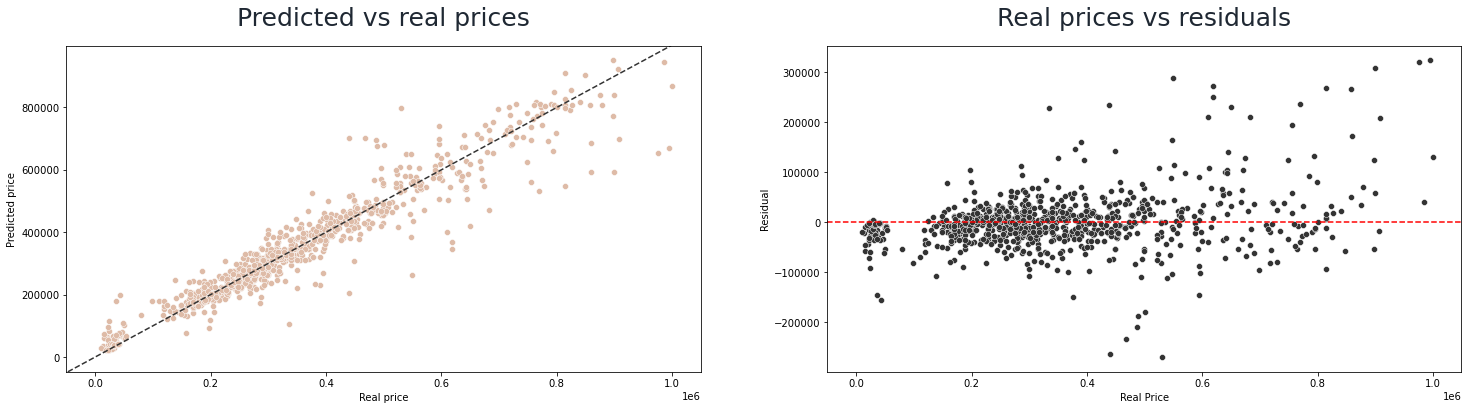

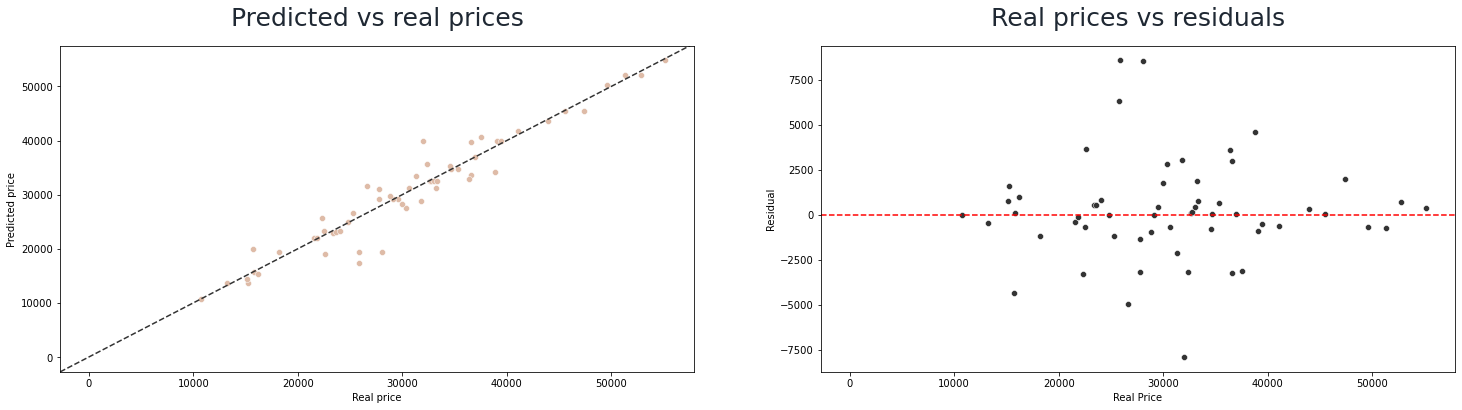

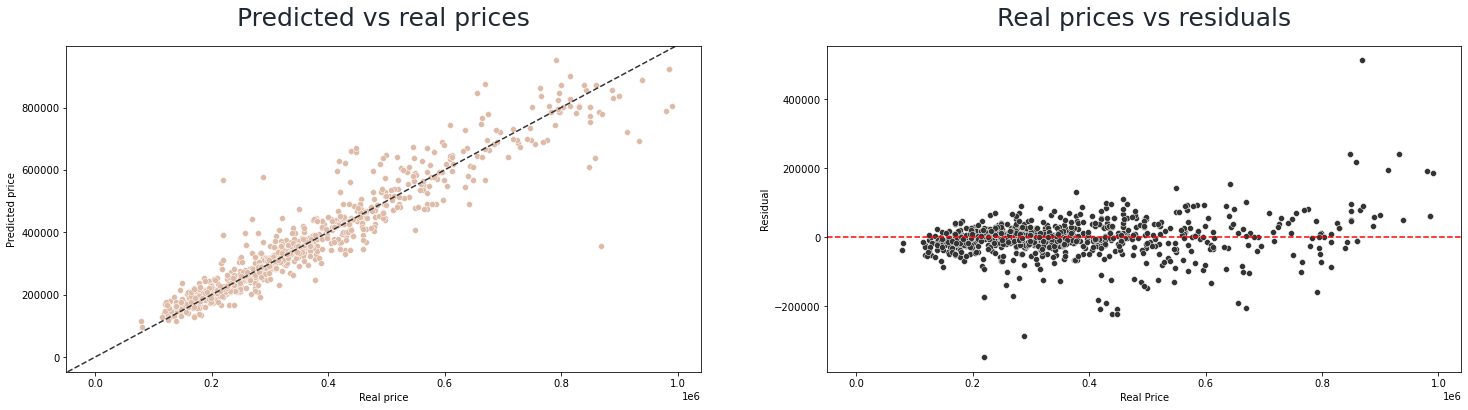

In [506]:
show_diagnostics(X_test,y_test,model=xgb_model)
show_diagnostics(X_test_low,y_test_low,model=xgb_model_low)
show_diagnostics(X_test_high,y_test_high,model=xgb_model_high)

The two-model approach does seem like a better way considering the diagnostics statistics and the residual distributions. There is some heteroschedasticity still to be seen in the residual plots, and some outliers are not predicted nearly correct enough. Though, these models do give good predictions for most of the listings.

## Conclusion

We got the data using our self-built data scraper for Finnish house listings. Then we performed Exploratory Data Analysis to see what insights we could get from the data. Afterwards, we implemented several models to predict the price of the house using given features.   
Our models perform quite well, most notably the two-model approach where we fit two models: one for low priced houses and one for the rest. The explained variance for each of the models was almost 90%.      
This analysis and these models could be used to make an informed decision on giving suggestion prices for people who are selling their houses.  
This could also be used by potential house buyers to see if the house they are looking at has the features to match the price, or if the seller trying to overprice the listing.